<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/IR_7classes_train_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to google drive so that we can save the model
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# will get raw and segmented images from segments.ai. I am not changing the size of the image for now
!pip install --upgrade segments-ai

  Created wheel for segments-ai: filename=segments_ai-0.43-py3-none-any.whl size=13052 sha256=4c109b0db2bf477d2ef40ddd1cea1f17ed0ac50c8713f7a6848d798c5c2cfad5
  Stored in directory: /root/.cache/pip/wheels/ea/9d/46/8f95b647bff0b1afe2c046313ab910fadee2612ec067b35275
Successfully built segments-ai


In [ ]:
from segments import SegmentsClient
api_key = "a89182567b17766b91773021b18d04574cd75109"
client = SegmentsClient(api_key)

Initialized successfully.


In [ ]:
# get the release file
dataset_identifier = "ssnirgudkar/IR-2020-10-22-17-33-25-0"
name = "V2.0"
release = client.get_release(dataset_identifier, name)
print(release)

{'uuid': '13189c97-ebd6-4b06-a2dd-779e7bf5b81f', 'name': 'V2.0', 'description': 'Labels are finalized', 'release_type': 'JSON', 'attributes': {'url': 'https://segmentsai-prod.s3.eu-west-2.amazonaws.com/releases/13189c97-ebd6-4b06-a2dd-779e7bf5b81f.json'}, 'status': 'SUCCEEDED', 'status_info': '', 'created_at': '2021-06-19T18:45:20.180168Z', 'samples_count': 62}


In [ ]:
# export the release. This exports both the raw image and the labeled image 
from segments import SegmentsDataset
from segments.utils import export_dataset
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled', 'reviewed'])

# Export to COCO panoptic format
export_dataset(dataset, export_format='coco-panoptic')


  0%|          | 0/62 [00:00<?, ?it/s]

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 62/62 [00:04<00:00, 13.36it/s]


Initialized dataset with 62 images.
Exporting dataset. This may take a while...


100%|██████████| 62/62 [00:02<00:00, 22.50it/s]

Exported to ./export_coco-panoptic_ssnirgudkar_IR-2020-10-22-17-33-25-0_V2.0.json. Images and labels in segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0


('./export_coco-panoptic_ssnirgudkar_IR-2020-10-22-17-33-25-0_V2.0.json',
 'segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0')

In [ ]:
# code to convert the instance ids to category ids

import os
import sys
import json
import argparse
import cv2
import numpy as np

WASR_SKY_ID = 2
WASR_WATER_ID = 1
WASR_OBSTACLE_ID = 0
MAX_ID = WASR_SKY_ID+1 # This can change in future.
# These labels should be read from JSON file but for now are hard-coded.
OUR_SKY_ID = 0
OUR_WATER_ID = 1
OUR_STRUCTURE_ID = 2
OUR_OBSTACLE_ID = 3
OUR_LIVING_OBSTACLE_ID = 4
OUR_BACKGROUND_ID = 5
OUR_SELF_ID = 6

TOTAL_INSTANCES = 20

# userlabel can be anything such as 'ground-truth' or 'segmentation'

def readJSONFile(jsonFilePath, userlabel):
    fileH = open(jsonFilePath)
    data = json.load(fileH)

    #print(data)
    dictImageRemap = {}
    
    for index in data['dataset']['samples']:
        #print("record of = {0}".format(index['name']))
        # The instance ids 'id' in JSON file can technically have no upper bound. This is because
        # if there are number of objects in the scene, instance ids will just keep increasing.
        # So the below number needs to be adjusted depending on what you find in JSON file.
        # If JSON file has larger number in its 'id' field than below then adjust the number below
        # to match the high number in JSON file. Specifically it is 'number+1'.
        mapIds = [None] * TOTAL_INSTANCES
        #print(index['name'], index['labels']['ground-truth']['attributes']['annotations'])
        # if images are not labeled then JSON file will contain 
        # ground-truth = null. Handle the case of if index['labels']['ground-truth'] exists
        if index['labels'][userlabel] is not None:
            #print("len(index['labels']['ground-truth'])={0}".format(len(index['labels']['ground-truth'])))
            if 'attributes' in index['labels'][userlabel]:
                if len(index['labels'][userlabel]['attributes']['annotations']) > 0:
                    #print(i, index['labels']['ground-truth']['attributes']['annotations'][i]['category_id'], index['labels']['ground-truth']['attributes']['annotations'][i]['id'])
                    for jj in range(len(index['labels'][userlabel]['attributes']['annotations'])):
                        #print("id={0} will be replaced by".format(index['labels']['ground-truth']['attributes']['annotations'][jj]['id']))
                        #print("category_id={0}".format(index['labels'][userlabel]['attributes']['annotations'][jj]['category_id']))
                        #print("index['labels'][userlabel]['attributes']['annotations'][jj]['id']={0}".format(index['labels'][userlabel]['attributes']['annotations'][jj]['id']))
                        #print("index['labels'][userlabel]['attributes']['annotations'][jj]['category_id']={0}".format(index['labels'][userlabel]['attributes']['annotations'][jj]['category_id']))
                        mapIds[index['labels'][userlabel]['attributes']['annotations'][jj]['id']] = index['labels'][userlabel]['attributes']['annotations'][jj]['category_id']
                    #print("mapIds={0}".format(mapIds))    
        dictImageRemap[index['name']] = mapIds
        #print("dictImageRemap[index['name']]={0}".format(dictImageRemap[index['name']]))

    fileH.close()
    return dictImageRemap

# This function creates 2 mask image files for a single input mask image.
# First conversion is from segments.ai's instance segmentation map to semantic segmentation map
# Second conversion is from semantic segmentation map to wasr 3 classes map.
# By saving 2 separate mask images, it is easy to carry out experimentation.
# It is expected that the input files are resized appropriately by running imageutilities.py
# script so that its name conforms to the naming convention i.e. the file name contains "_".
def change_one_label_with_another_label(fileOrDirName, records):  

    def change_label(filename, mapRelabel):
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        if (img is None):
            print("Image = {0} does not exist.".format(filename))
        
        unique_values_img = np.unique(img)
        #print("Unique label ids in img = {0}".format(unique_values_img))

        img2 = img.copy()
        if len(img.shape) != 2:
            print("Skipping {0} because it contains channel information, mask image should be 2-D only.".format(filename))
            return

        height,width = img.shape

        dir_filename_pair = os.path.split(filename)
        #print("dir_filename_pair={0}".format(dir_filename_pair))
        ext = dir_filename_pair[-1][-4:]
        dirName = dir_filename_pair[:-1]
        #print("dir={0}".format(dirName[0]))
        oneDirUp = os.path.abspath(os.path.join(dirName[0], os.pardir))
        #print("oneDirUp={0}".format(oneDirUp))
        inputFileName = dir_filename_pair[-1]
        #print("inputFileName={0}".format(inputFileName))
        tokens2 = inputFileName.split('_')
        #print("tokens2={0}".format(tokens2))
        origImageName = tokens2[0] + ext
        #print("origImageName={0}".format(origImageName))
        rawfileName = dir_filename_pair[-1][:-4] # last token (-1) is full file name. (-4) is without ".png"

        
        semantic_segment_dir_name = os.path.join(oneDirUp, 'segment_relabel_semantic')
        #print("semantic_segment_dir_name={0}".format(semantic_segment_dir_name))
        semantic_segment_dir = semantic_segment_dir_name
        if not os.path.isdir(semantic_segment_dir_name):
            os.mkdir(semantic_segment_dir_name)
            #print("semantic_segment_dir={0}".format(semantic_segment_dir))
        
        outputfilename2 = rawfileName + "_relabeled_semantically" + ext
        fulloutputfilename2 = os.path.join(semantic_segment_dir, outputfilename2)

        #print("input file = {0}".format(inputFileName))
        mapOfThisFile = records[origImageName]
        #print("file={1}, mapOfThisFile={0}".format(mapOfThisFile, inputFileName))
        for i in range(height):
            for j in range(width):
                for k in range(len(mapOfThisFile)):
                    if ((img.item(i,j) == k) and (mapOfThisFile[k] is not None)):
                        #print("i={3},j={4},img.item(i,j)={0}, k={1}, mapOfThisFile[k]={2}".format(img.item(i,j), k, mapOfThisFile[k],i,j))
                        img2.itemset((i,j), mapOfThisFile[k])

        cv2.imwrite(fulloutputfilename2, img2)

        ''' this is for 3 classes. hence commented 
        unique_values_img2 = np.unique(img2)
        #print("Unique label ids in img2 = {0}".format(unique_values_img2))

        relabel2_wasr3_dir_name = os.path.join(oneDirUp, 'segment_relabel2_wasr3')
        relabel2_wasr3_dir = relabel2_wasr3_dir_name
        if not os.path.isdir(relabel2_wasr3_dir_name):
            os.mkdir(relabel2_wasr3_dir_name)

        outputfilename3 = rawfileName + "_relabeled_to3wasrclasses" + ext
        fulloutputfilename3 = os.path.join(relabel2_wasr3_dir, outputfilename3)
        our2WasrMap = [None] * 8
        our2WasrMap[OUR_SKY_ID] = WASR_SKY_ID
        our2WasrMap[OUR_WATER_ID] = WASR_WATER_ID
        our2WasrMap[OUR_STRUCTURE_ID] = WASR_OBSTACLE_ID
        our2WasrMap[OUR_OBSTACLE_ID] = WASR_OBSTACLE_ID
        # Keep the remaining labels intact
        our2WasrMap[OUR_LIVING_OBSTACLE_ID] = our2WasrMap[OUR_BACKGROUND_ID] = our2WasrMap[OUR_SELF_ID] = WASR_OBSTACLE_ID
        img3 = img2.copy()

        #print("ours2Wasrmap={0}".format(our2WasrMap))

        for i in range(height):
            for j in range(width):
                for k in range(len(our2WasrMap)):
                    if ((img2.item(i,j) == k) and (our2WasrMap[k] is not None)):
                        #print("img2.item(i,j)={0}, k={1}, our2WasrMap[k]={2}".format(img2.item(i,j), k, our2WasrMap[k]))
                        img3.itemset((i,j), our2WasrMap[k])


        unique_values_img3 = np.unique(img3)
        print("Unique label ids in img3 = {0}".format(unique_values_img3))
        maxId = max(unique_values_img3)
        if (maxId >= MAX_ID):
            raise Exception("Conversion not correct for file:{0}".format(filename))

        cv2.imwrite(fulloutputfilename3, img3)            
        '''
    if (os.path.isdir(fileOrDirName)):
        for eachFile in os.listdir(fileOrDirName):
            if (eachFile.endswith("ground-truth.png") or eachFile.endswith(".jpg")):
                eachFileFullPath = os.path.join(fileOrDirName, eachFile)
                print("eachFile = {0}".format(eachFileFullPath))
                change_label(eachFileFullPath, records)
    else:
        change_label(fileOrDirName, records)    

print("calling read json file")     
records = readJSONFile("/content/IR-2020-10-22-17-33-25-0-V2.0.json", "ground-truth")
print("calling label change")
change_one_label_with_another_label("/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0", records)
print("end change label")


Because the trainning code is for classes and different image size, I will create new training code here. Above the pixel values have been changed to category ids. Size of the image is same as that in segments.ai 


In [ ]:
# read the downloaded files and check the pixel values to make sure they are right

import os
import numpy as np
import cv2

input_dir = "/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0" # directory containing input raw images
target_dir = "/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic" # directory containing labeled images
img_size = (512, 640) #it's height and width. it's a 1/2 sized image from the original image from segment.ai
num_classes = 7
batch_size = 5

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png") and ("ground-truth" not in fname)
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith("semantically.png")  
    ]
)

#prints how many files are in the batch
print("Number of samples:", len(input_img_paths))

#prints the name of 10 sets of input and labeled file
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

#below code checks if the labels are in the 1 through 3 range (4 classes - sky,water,object,background). 
#Because if not, then model training gives a NAN error.
#it displays the label file that has an error, and the values of the label
ideal_label_array = [0,1,2,3,4,5,6] # depends on the number of classes
flag = 0 
for target_path in (target_img_paths):
    target_label_array = (np.unique(cv2.imread(target_path,cv2.IMREAD_UNCHANGED)))
    if(set(target_label_array).issubset(set(ideal_label_array))):
       flag +=1
       #print("good label", flag)
    else:    
       flag +=1
       print("Error in label", flag,target_path,target_label_array )  

Number of samples: 62
/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388082.940481.png | /content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388082.940481_label_ground-truth_relabeled_semantically.png
/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388099.294270.png | /content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388099.294270_label_ground-truth_relabeled_semantically.png
/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388115.497458.png | /content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388115.497458_label_ground-truth_relabeled_semantically.png
/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388165.895730.png | /content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388165.895730_label_ground-truth_relabeled_semantically.png
/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/160338

Prepare Sequence class to load & vectorize batches of data


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            #in case we want to see if masked image have the right values
            #print(tensorflow.keras.preprocessing.image.img_to_array(img))
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2: 
            #if classes are 3, keras expects masked values to be 0,1,2 only. Cannot take 1,3,5. It checks numerically not just the number of masked values
            #y[j] += 1 
        return x, y


## Prepare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2 ,padding="same",kernel_initializer = 'uniform')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'uniform')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'uniform')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same", )(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same",  kernel_initializer = 'uniform')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1,padding="same", kernel_initializer = 'uniform')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",kernel_initializer = 'uniform')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 320, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 5
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

import tensorflow as tf
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    #commenting checkpoint because i am going to save the entire model and start with earlier model
    #keras.callbacks.ModelCheckpoint("IR_1000images_he_normal_adam_softmax_relu_300_10_1.h5", save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# Train the model, doing validation at the end of each epoch. This will be the first time code. Thereafter, you first load the saved model and then train again
epochs = 100
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Save the model after training  
model.save("/content/drive/MyDrive/Models/UNet_7classes_1.0")

# now load the model for the next run 
#reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")

# now re-train on the saved model - this will be from run2
#epochs = 100
#reconstructed_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
11/11 [==============================] - 23s 448ms/step - loss: 0.7886 - val_loss: 2.1785
Epoch 2/100
11/11 [==============================] - 4s 337ms/step - loss: 0.0998 - val_loss: 6.0031
Epoch 3/100
11/11 [==============================] - 4s 334ms/step - loss: 0.0660 - val_loss: 13.6984
Epoch 4/100
11/11 [==============================] - 4s 335ms/step - loss: 0.0769 - val_loss: 18.2528
Epoch 5/100
11/11 [==============================] - 4s 334ms/step - loss: 0.0628 - val_loss: 23.4875
Epoch 6/100
11/11 [==============================] - 4s 332ms/step - loss: 0.0754 - val_loss: 17.6160
Epoch 7/100
11/11 [==============================] - 4s 334ms/step - loss: 0.0544 - val_loss: 15.6555
Epoch 8/100
11/11 [==============================] - 4s 333ms/step - loss: 0.0447 - val_loss: 12.5707
Epoch 9/100
11/11 [==============================] - 4s 334ms/step - loss: 0.0405 - val_loss: 10.6938
Epoch 10/100
11/11 [==============================] - 4s 335ms/step - loss: 0.0365 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/UNet_7classes_1.0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/UNet_7classes_1.0/assets


## Train the Model - Run 2

In [ ]:
# after the 1st run, we can just run from this step on (excluding the files etc)

# now load the model for the next run 
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")

# now re-train on the saved model - this will be from run2
epochs = 1
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
reconstructed_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# now save the model back ### REMEMBER : ONLY save the modle if you know your run is with good data. 
# ELSE it will spoil all the prior learning
reconstructed_model.save("/content/drive/MyDrive/Models/UNet_7classes_1.0")

##Visualize predictions

['/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388452.556152.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603389110.873336.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388751.716032.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603389716.488182.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388933.294796.png']
['/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388452.556152_label_ground-truth_relabeled_semantically.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603389110.873336_label_ground-truth_relabeled_semantically.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388751.716032_label_ground-truth_relabeled_semantically.png', '/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603389716.488182_label_ground-truth_relabeled_sema

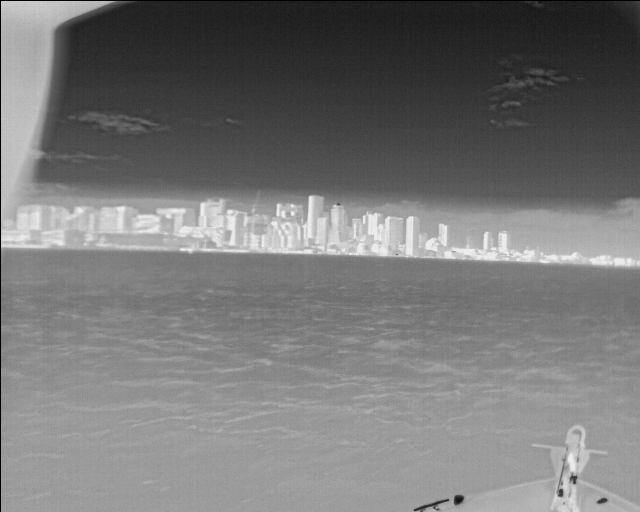

this is the labeled image


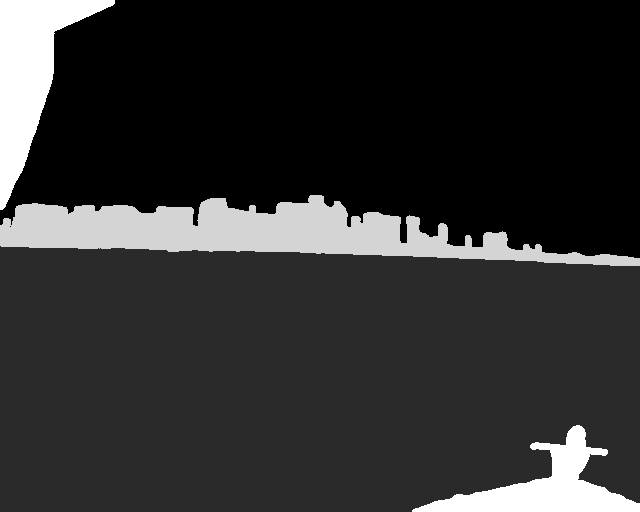

(512, 640, 1)
1
640
<class 'PixelAccess'>
(0, 0, 0)
this is the colored inferred image


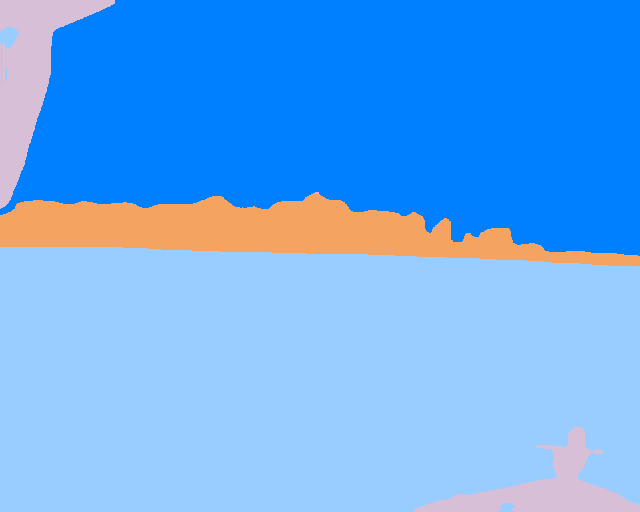

this is the gray inferred image


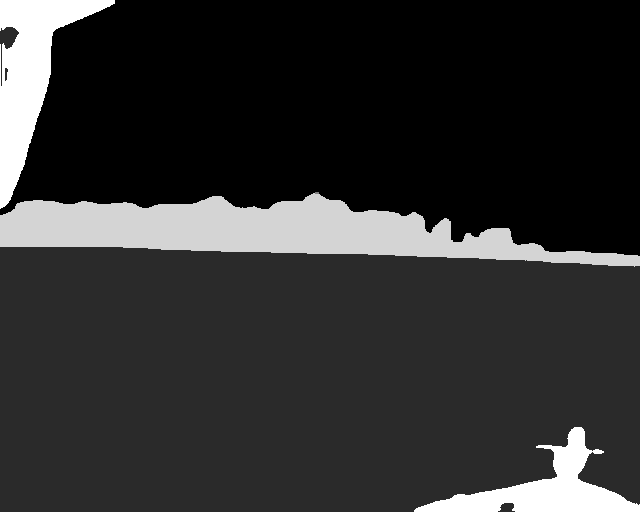

In [ ]:
print(val_input_img_paths)
print(val_target_img_paths)
print(type(val_input_img_paths))

# Generate predictions for all images in the validation set

from IPython.display import Image, display
import PIL
from PIL import ImageOps
#from PIL import Image

1603388318.501611
#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_input_img_paths_test = ['/content/drive/MyDrive/poorlighting_brightlight_resized/1603208980.690948_resized.png']
val_input_img_paths_test = ['/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/V2.0/1603388082.940481.png']
val_target_img_paths_test = ['/content/segments/ssnirgudkar_IR-2020-10-22-17-33-25-0/segment_relabel_semantic/1603388082.940481_label_ground-truth_relabeled_semantically.png']


#print(type(val_input_img_paths_test))

val_gen = OxfordPets(1, img_size, val_input_img_paths_test, val_target_img_paths_test)
# we will use model for the 1st run. and then reconstructed_model from run 2
val_preds = model.predict(val_gen)

#predict using the saved model - run 2 on 
#val_preds = reconstructed_model.predict(val_gen)


def display_mask(i):
    '''Quick utility to display a model's prediction. we need color masked images, so displaying both color and black and white"""
    OUR_SKY_ID = 0.  - 0080FF - (0,128,255)  
    OUR_WATER_ID = 1.  - CCE5FF - (153,204,255)
    OUR_STRUCTURE_ID = 2 - indian red - (205,92,92)
    OUR_OBSTACLE_ID = 3 - FF99FF - (255,153,255)
    OUR_LIVING_OBSTACLE_ID = 4 - 00FF00 -(0,255,0) 
    OUR_BACKGROUND_ID = 5 - sandy brown - (244,164,96)
    OUR_SELF_ID = 6 - thistle - (216,191,216)
    '''
    label_colours = [(0,128,255), (153,204,255), (205,92,92),(255,153,255), (0,255,0), (244,164,96), (216,191,216)]  
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    print(np.shape(mask))
    print(len(mask[i, 0]))
    print(len(mask[i]))

    img1 = PIL.Image.new('RGB', (640, 512))
    pixels = img1.load()
    print(type(pixels))
    print(pixels[0,0])
    for j_, j in enumerate(mask[:, :, 0]):
        #print (j_, j)
        for k_, k in enumerate(j):
              #print(k_, k)
              if k < num_classes:
                  pixels[k_,j_] = label_colours[k]
    output = np.array(img1)
    
    print("this is the colored inferred image")
    display(img1)
  

    print("this is the gray inferred image")
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #40. it uses val_inpit_images. so will only pick from the ones that we have kept for validation.
i = 0

# Display input image
print("this is the raw image")
display(Image(filename=val_input_img_paths_test[i]))

# Display ground-truth target mask
print("this is the labeled image")
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths_test[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.